In [62]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
from gensim.corpora import Dictionary
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer

import torch
from torch import nn
from torch.distributions import constraints
import functools

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, JitTraceEnum_ELBO, TraceEnum_ELBO
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoGuideList, AutoDelta
from pyro.optim import ClippedAdam

# Download required resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emilk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\emilk\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\emilk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
# Load the dataset and drop nans
df = pd.read_csv("tmdb_5000_movies.csv")
df.dropna(subset=['overview'], inplace=True)

In [64]:
df.loc[0, 'overview']

'In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, but becomes torn between following orders and protecting an alien civilization.'

In [65]:
MAX_WORDS = 1000

vectorizer = CountVectorizer(
    max_df=0.95, min_df=2, max_features=MAX_WORDS, stop_words="english"
)

def VectorizeText(text, vectorizer):
    X_count = vectorizer.fit_transform(df['overview'])
    list_of_word_indices_per_doc = []
    if hasattr(X_count, 'indptr'): # Check if it's likely CSR or similar
        for i in range(X_count.shape[0]): # Iterate through each document/row
            word_indices_for_doc_i = X_count[i].indices
            list_of_word_indices_per_doc.append(word_indices_for_doc_i.tolist())

    return list_of_word_indices_per_doc

def add_mask_column(df, column_name, length, new_column_name='masked_list'):
    def pad_and_create_mask(lst):
        # Truncate if list is longer than the specified length
        truncated = lst[:length]
        
        # Create mask: 1s for actual values, 0s for padding
        mask = [1] * len(truncated)
        padding_length = max(0, length - len(truncated))
        mask += [0] * padding_length

        # Pad list with 0s if shorter than desired length
        padded_lst = truncated + [0] * padding_length

        return padded_lst, mask

    # Apply padding and mask creation
    result = df[column_name].apply(pad_and_create_mask)
    df[column_name] = result.apply(lambda x: x[0])  # overwrite with padded/truncated list
    df[new_column_name] = result.apply(lambda x: x[1])  # add mask column
    return df

def get_words(index_list, vectorizer):
    words = []
    for i in index_list:
        words.append(vectorizer.get_feature_names_out()[i])
    return words

In [66]:
# Create index lists of words for each document
list_of_word_indices_per_doc = VectorizeText(df['overview'], vectorizer)
df["overview_indexed"] = list_of_word_indices_per_doc
df['overview_length'] = df['overview_indexed'].apply(len)
df.shape

(4800, 22)

In [ ]:
print(list_of_word_indices_per_doc[0])
print(get_words(list_of_word_indices_per_doc[0], vectorizer))

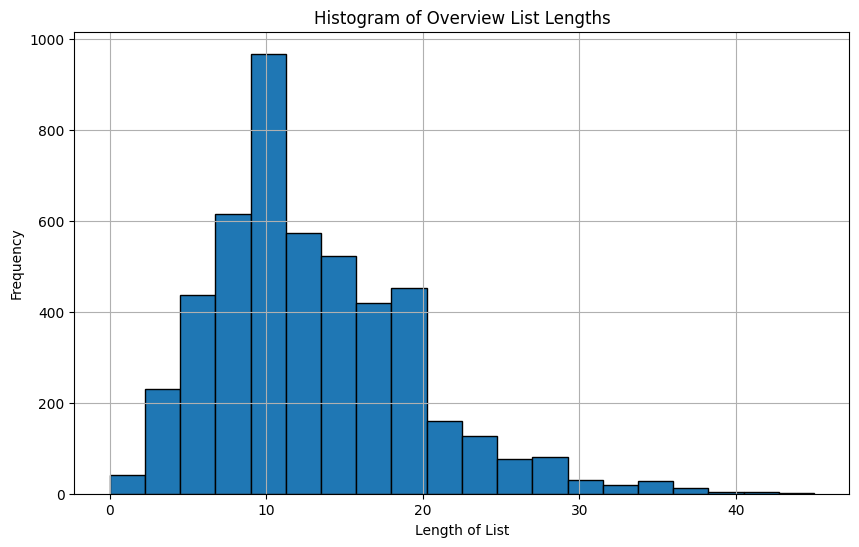

In [67]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df['overview_length'], bins=20, edgecolor='black')
plt.title('Histogram of Overview List Lengths')
plt.xlabel('Length of List')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [76]:
NUM_WORDS = MAX_WORDS
NUM_DOCS = df.shape[0]
NUM_TOPICS = 10
NUM_WORDS_PER_DOC = 50

In [77]:
print(NUM_DOCS)

4800


In [81]:
# Create a mask column for the dataframe
df = add_mask_column(df, 'overview_indexed', length=NUM_WORDS_PER_DOC, new_column_name="overview_masked")

In [82]:
W = df["overview_indexed"]
Mask = df["overview_masked"]

# Convert to a LongTensor (2D tensor)
tensor_W = torch.tensor(W.tolist(), dtype=torch.long).T
tensor_Mask = torch.tensor(Mask.tolist(), dtype=torch.bool).T

In [83]:
print(tensor_W.shape)
print(tensor_Mask.shape)

torch.Size([50, 4800])
torch.Size([50, 4800])


In [84]:
def model(data=None, mask=None, batch_size=None):
    """LDA model with masking for variable-length documents."""
    with pyro.plate("topics", NUM_TOPICS):
        topic_words = pyro.sample(
            "topic_words", dist.Dirichlet(torch.ones(NUM_WORDS) / NUM_WORDS)
        )

    with pyro.plate("documents", NUM_DOCS, batch_size) as ind:
        data = data[:, ind]  # data: [max_words, batch_size]
        if mask is not None:
            mask = mask[:, ind]  # same shape as data

        doc_topics = pyro.sample(
            "doc_topics", dist.Dirichlet(torch.ones(NUM_TOPICS) / NUM_TOPICS)
        )

        with pyro.plate("words", NUM_WORDS_PER_DOC):
            with pyro.poutine.mask(mask=mask):
                word_topics = pyro.sample(
                    "word_topics", dist.Categorical(doc_topics),
                    infer={"enumerate": "parallel"}
                )

                doc_words = pyro.sample(
                    "doc_words",
                    dist.Categorical(topic_words[word_topics]),
                    obs=data
                )

    return topic_words, doc_words

In [ ]:
pyro.clear_param_store()

def my_local_guide(data=None, mask=None, batch_size=None):
    topic_words_posterior = pyro.param(
            "topic_words_posterior",
            lambda: torch.ones(NUM_TOPICS, NUM_WORDS),
            constraint=constraints.positive)
    
    with pyro.plate("topics", NUM_TOPICS):
        pyro.sample("topic_words", dist.Dirichlet(topic_words_posterior))
    
    doc_topics_posterior = pyro.param(
            "doc_topics_posterior",
            lambda: torch.ones(NUM_DOCS, NUM_TOPICS),
            constraint=constraints.simplex)
    
    with pyro.plate("documents", NUM_DOCS, batch_size) as ind:
        pyro.sample("doc_topics", dist.Delta(doc_topics_posterior[ind], event_dim=1))


guide = my_local_guide

elbo = TraceEnum_ELBO(max_plate_nesting=3)

optim = ClippedAdam({'lr': 0.005})
svi = SVI(model, guide, optim, elbo)

# Define the number of optimization steps
n_steps = 4000

# do gradient steps
for step in range(n_steps):
    elbo = svi.step(tensor_W, tensor_Mask, batch_size=32)
    if step % 100 == 0:
        #print('.', end='')
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 1807146.8
[100] ELBO: 1593094.4
[200] ELBO: 1408744.4
[300] ELBO: 1297420.5
[400] ELBO: 1137940.8
[500] ELBO: 944185.5
[600] ELBO: 848327.4
[700] ELBO: 751294.8
[800] ELBO: 716028.4
[900] ELBO: 725454.5
[1000] ELBO: 683065.1
[1100] ELBO: 621368.3
[1200] ELBO: 655314.1
[1300] ELBO: 656318.2
[1400] ELBO: 614256.1
[1500] ELBO: 681933.1
[1600] ELBO: 634278.3
[1700] ELBO: 632767.2
[1800] ELBO: 626580.4
[1900] ELBO: 682529.2
[2000] ELBO: 756475.1
[2100] ELBO: 714492.1
[2200] ELBO: 756131.0
[2300] ELBO: 712502.6
[2400] ELBO: 673958.8
[2500] ELBO: 821819.0
[2600] ELBO: 791957.8
[2700] ELBO: 837567.2
[2800] ELBO: 739876.1
[2900] ELBO: 760841.1
[3000] ELBO: 724078.4
[3100] ELBO: 781463.1
[3200] ELBO: 778474.4
[3300] ELBO: 795278.3
[3400] ELBO: 716411.9
[3500] ELBO: 804758.7
[3600] ELBO: 894710.8
[3700] ELBO: 810113.1
[3800] ELBO: 852703.9


In [ ]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=100,
                        return_sites=("topic_words",))
samples = predictive(tensor_W,
                     tensor_Mask,
                     batch_size=4)

topics = samples["topic_words"]
topics = topics[:, 0].mean(axis=0)

In [ ]:
feature_names = vectorizer.get_feature_names_out()
for i in range(NUM_TOPICS):
    topic = topics[i]
    top_10 = topic.argsort(descending=True)[:10]
    top_words = [feature_names[int(idx)] for idx in top_10]
    print(f"Top 10 words for Topic {i}:")
    for i in range(10):
        print(f"{i+1}: {top_words[i]}")